In [1]:
#!pip install segmentation-models-pytorch

#### Библиотеки

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import albumentations as A
from torch.utils.data import DataLoader
import torch
import cv2
from torch.utils.data import Dataset
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from sklearn.model_selection import train_test_split
from tqdm import tqdm

#### Параметры 

In [5]:
# Пути
TRAIN_DATA_PATH = 'Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = ''

# Устройство
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Параметры
EPOCHS = 10        # количество эпох
LR = 0.001         # LR
IMG_SIZE = 320     # Размер картинки
BATCH_SIZE = 32    # Размер батча

# Определяем предобученный енкодер  и веса 
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

#### Данные
- Данные содержат изображения людей с информацией в виде масок

In [7]:
df = pd.read_csv(TRAIN_DATA_PATH)
print(df.shape)
df.head()

(290, 2)


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
sample = df.iloc[np.random.randint(0, df.shape[0], size=5)]

def generate_sample_images(sample):
    imgs = sample.images

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, image in enumerate(imgs):
        image = cv2.imread(image)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_title("IMAGE")
        ax[i].imshow(image)

def generate_sample_masks(sample):
    masks = sample.masks

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, mask in enumerate(masks):
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE) / 255.0

        ax[i].set_title("GROUND TRUTH")
        ax[i].imshow(mask, cmap='gray')

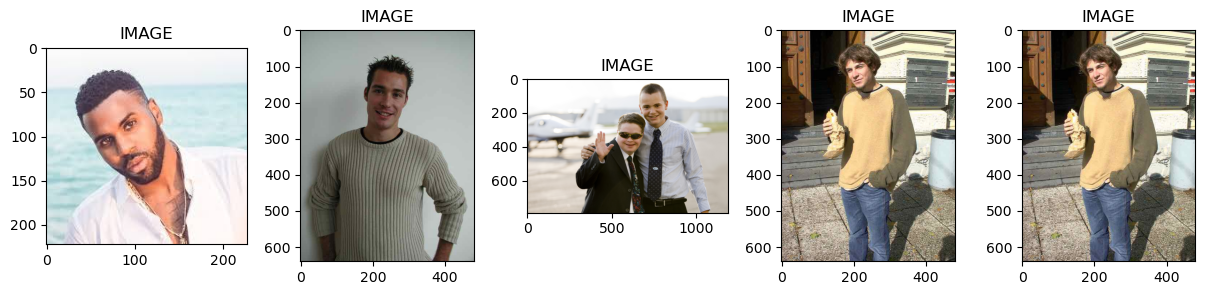

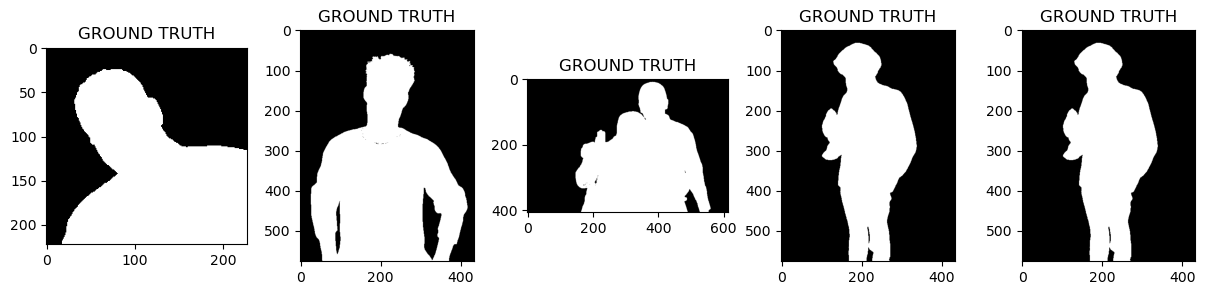

In [9]:
# Примеры из датасета
generate_sample_images(sample)
generate_sample_masks(sample)

In [10]:
# Создание обучающей, валидационной и тестовой выборок 
# 80% на обучение, 10% на валидацию, 10% на тест
train_df, val_df = train_test_split(df, test_size=0.2, random_state=15)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=15)


In [11]:
# Аугментация
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
    ], is_check_shapes=False)

def get_val_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)

In [12]:
# Класс для работы с данными
class SegmentationDataset(Dataset):
    def __init__(self, df, augs):
        self.df = df
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        image = sample.images
        mask = sample.masks
        
        # Чтение изображений и масок
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)
        
        
        
        # Применяем аугментацию
        if self.augs:
            data = self.augs(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
            
        
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)
        
        # Нормализовать изображения и маски
        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [13]:
train_data = SegmentationDataset(train_df, get_train_augs())
val_data = SegmentationDataset(val_df, get_val_augs())
test_data = SegmentationDataset(test_df, get_val_augs())

In [14]:
# Создаем деталодеры
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

#### Модели

In [16]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.model = smp.UnetPlusPlus(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None)

    def forward(self, images, masks=None):
        logits = self.model(images)

        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits

In [17]:
model = SegmentationModel()
model.to(DEVICE);

In [18]:
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [19]:
def eval_model(data_loader, model):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()

        return total_loss / len(data_loader)

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [21]:
best_val_loss = 1000000000
for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    val_loss = eval_model(valloader, model)

    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_model_base.pt')
        print("MODEL SAVED")
        
        best_val_loss = val_loss

    print(f"\033[1m\033[92m Epoch {i+1} Train Loss {train_loss} Val Loss {val_loss}")

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.78s/it]


MODEL SAVED
 Epoch 1 Train Loss 1.1828770637512207 Val Loss 3.0158984661102295


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.74s/it]


MODEL SAVED
 Epoch 2 Train Loss 0.714456208050251 Val Loss 0.7149724960327148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


MODEL SAVED
 Epoch 3 Train Loss 0.49829360842704773 Val Loss 0.43957239389419556


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


MODEL SAVED
 Epoch 4 Train Loss 0.40174809098243713 Val Loss 0.4133724272251129


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.74s/it]


MODEL SAVED
 Epoch 5 Train Loss 0.31490732356905937 Val Loss 0.37582042813301086


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


MODEL SAVED
 Epoch 6 Train Loss 0.24728954210877419 Val Loss 0.3331579864025116


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


MODEL SAVED
 Epoch 7 Train Loss 0.20250018686056137 Val Loss 0.2344244122505188


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.69s/it]


MODEL SAVED
 Epoch 8 Train Loss 0.15946975722908974 Val Loss 0.2226943075656891


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


MODEL SAVED
 Epoch 9 Train Loss 0.13542955089360476 Val Loss 0.2017548382282257


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.73s/it]


MODEL SAVED
 Epoch 10 Train Loss 0.12073960900306702 Val Loss 0.20068910717964172


In [22]:
def make_inference(idx):
    image, mask = val_data[idx]
    logits_mask = model(image.to(DEVICE).unsqueeze(0)) 

    
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5) * 1.0
    
    return image, mask, pred_mask

In [23]:
model.load_state_dict(torch.load("best_model_base.pt"))

<All keys matched successfully>

In [24]:
eval_model(testloader, model)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.83s/it]


0.18172809481620789

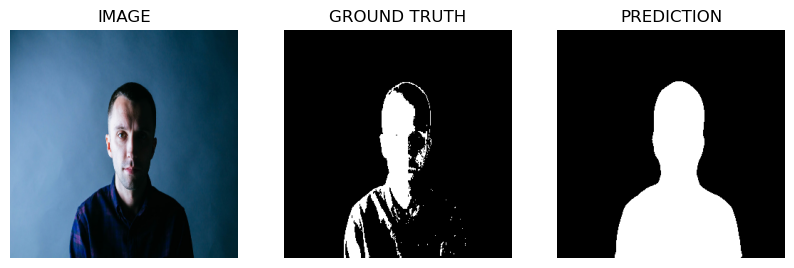

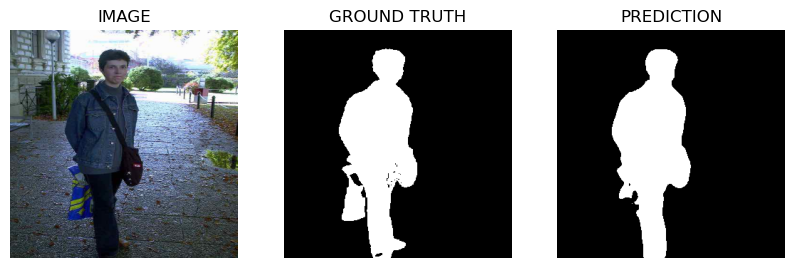

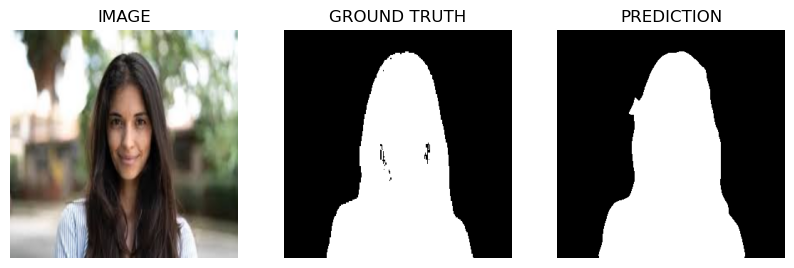

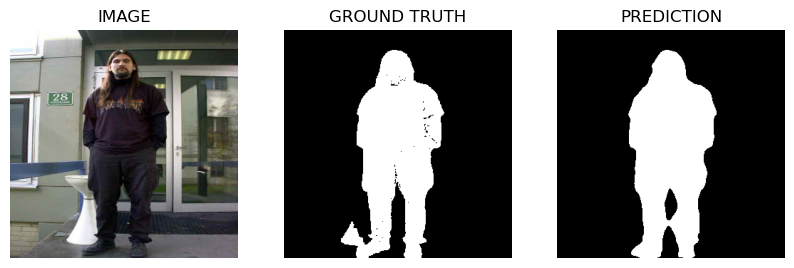

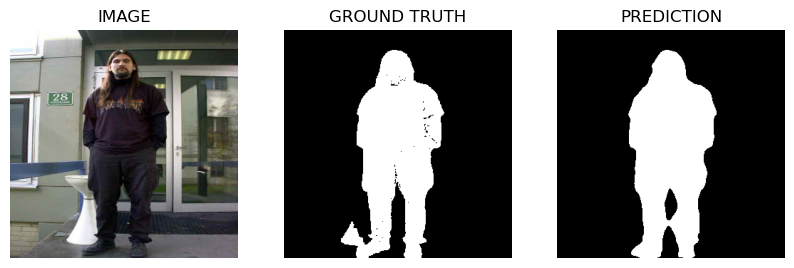

In [25]:
for i in np.random.randint(0, len(val_data), 5):
    image, mask, pred_mask = make_inference(i)
    
    # Show image
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.title('IMAGE');

    # Show original mask
    plt.subplot(1,3,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('GROUND TRUTH');

    # Show predicted mask
    plt.subplot(1,3,3)
    plt.imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('PREDICTION');

#### Гипотезы
- Увеличение lr с LR = 0.001 до 0.1 увеличит точность на тестовой выборке
- Добавлнение большего количества аугментаций увеличит точность на тестовой выборке

In [27]:
LR = 0.1
model = SegmentationModel()
model.to(DEVICE);
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [28]:
best_val_loss = 1000000000
for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    val_loss = eval_model(valloader, model)

    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_model_new_lr.pt')
        print("MODEL SAVED")
        
        best_val_loss = val_loss

    print(f"\033[1m\033[92m Epoch {i+1} Train Loss {train_loss} Val Loss {val_loss}")

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


 Epoch 1 Train Loss 1.384920820593834 Val Loss 6054503514112.0


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.03s/it]


MODEL SAVED
 Epoch 2 Train Loss 1.068690612912178 Val Loss 58984288.0


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


MODEL SAVED
 Epoch 3 Train Loss 0.9424560740590096 Val Loss 1057.53466796875


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


MODEL SAVED
 Epoch 4 Train Loss 0.8705402761697769 Val Loss 31.659961700439453


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


MODEL SAVED
 Epoch 5 Train Loss 0.7873930335044861 Val Loss 25.96565055847168


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.03s/it]


MODEL SAVED
 Epoch 6 Train Loss 0.7529564425349236 Val Loss 15.745041847229004


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


MODEL SAVED
 Epoch 7 Train Loss 0.7391448691487312 Val Loss 3.6097121238708496


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


MODEL SAVED
 Epoch 8 Train Loss 0.6892873495817184 Val Loss 1.1105074882507324


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


 Epoch 9 Train Loss 0.7065909057855606 Val Loss 1.3114326000213623


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


MODEL SAVED
 Epoch 10 Train Loss 0.6858700439333916 Val Loss 0.9589134454727173


In [29]:
model.load_state_dict(torch.load("best_model_new_lr.pt"))

<All keys matched successfully>

In [30]:
eval_model(testloader, model)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


1.3341751098632812

#### Выводы 
- Увеличение lr понизило точность модели на тестовых данных

In [32]:
LR = 0.001
model = SegmentationModel()
model.to(DEVICE);
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [33]:
# Добавляем 
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),      
        A.VerticalFlip(p=0.5)         
    ], is_check_shapes=False)

def get_val_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)


# Класс для работы с данными
class SegmentationDataset(Dataset):
    def __init__(self, df, augs):
        self.df = df
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        image = sample.images
        mask = sample.masks
        
        # Чтение изображений и масок
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)
        
        
        
        # Применяем аугментацию
        if self.augs:
            data = self.augs(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
            
        
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)
        
        # Нормализовать изображения и маски
        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [34]:
train_data = SegmentationDataset(train_df, get_train_augs())
val_data = SegmentationDataset(val_df, get_val_augs())
test_data = SegmentationDataset(test_df, get_val_augs())

In [35]:
# Создаем деталодеры
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [36]:
best_val_loss = 1000000000
for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    val_loss = eval_model(valloader, model)

    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_model_new_aug.pt')
        print("MODEL SAVED")
        
        best_val_loss = val_loss

    print(f"\033[1m\033[92m Epoch {i+1} Train Loss {train_loss} Val Loss {val_loss}")

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


MODEL SAVED
 Epoch 1 Train Loss 1.0655540749430656 Val Loss 1.9955801963806152


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


MODEL SAVED
 Epoch 2 Train Loss 0.5995433330535889 Val Loss 0.5510643720626831


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


MODEL SAVED
 Epoch 3 Train Loss 0.39793679863214493 Val Loss 0.340221107006073


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.80s/it]


MODEL SAVED
 Epoch 4 Train Loss 0.28350151889026165 Val Loss 0.3230651021003723


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.69s/it]


MODEL SAVED
 Epoch 5 Train Loss 0.21315101347863674 Val Loss 0.25326812267303467


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


MODEL SAVED
 Epoch 6 Train Loss 0.18555258959531784 Val Loss 0.23470254242420197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


MODEL SAVED
 Epoch 7 Train Loss 0.1536103244870901 Val Loss 0.2117416262626648


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.74s/it]


 Epoch 8 Train Loss 0.140383574180305 Val Loss 0.22020182013511658


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.80s/it]


 Epoch 9 Train Loss 0.12658568751066923 Val Loss 0.24099351465702057


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.92s/it]

 Epoch 10 Train Loss 0.13485382590442896 Val Loss 0.2206403762102127


In [37]:
model.load_state_dict(torch.load("best_model_new_aug.pt"))

<All keys matched successfully>

In [38]:
eval_model(testloader, model)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.82s/it]


0.18680964410305023

#### Выводы 
- Применение аугментации незначительно повысило качество на тествой выборке 

##### Обучение улучшенного бейзлайна

In [82]:
LR = 0.001
model = SegmentationModel()
model.to(DEVICE);
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [83]:
best_val_loss = 1000000000
for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    val_loss = eval_model(valloader, model)

    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_model_better_baseline.pt')
        print("MODEL SAVED")
        
        best_val_loss = val_loss

    print(f"\033[1m\033[92m Epoch {i+1} Train Loss {train_loss} Val Loss {val_loss}")

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.55s/it]


MODEL SAVED
 Epoch 1 Train Loss 1.0510577633976936 Val Loss 1.9547702074050903


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


MODEL SAVED
 Epoch 2 Train Loss 0.5903113670647144 Val Loss 0.5575978755950928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


MODEL SAVED
 Epoch 3 Train Loss 0.399636197835207 Val Loss 0.3316759467124939


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


MODEL SAVED
 Epoch 4 Train Loss 0.28915002197027206 Val Loss 0.2811848521232605


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


MODEL SAVED
 Epoch 5 Train Loss 0.22696314193308353 Val Loss 0.227270245552063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


MODEL SAVED
 Epoch 6 Train Loss 0.18586832284927368 Val Loss 0.2153056412935257


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


MODEL SAVED
 Epoch 7 Train Loss 0.15966645069420338 Val Loss 0.2134755551815033


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.05s/it]


MODEL SAVED
 Epoch 8 Train Loss 0.15740459598600864 Val Loss 0.20163337886333466


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


 Epoch 9 Train Loss 0.16752145159989595 Val Loss 0.2142866551876068


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


MODEL SAVED
 Epoch 10 Train Loss 0.13825214467942715 Val Loss 0.1912710815668106


In [84]:
model.load_state_dict(torch.load("best_model_better_baseline.pt"))

<All keys matched successfully>

In [85]:
eval_model(testloader, model)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.34s/it]


0.18420252203941345